Simple regression problems have particular set of data and we try to predict new values from the same set of data which is called **Interpolation**

In Time Series we have a particular set of data which is in terms of time in the past and based on that we need to predic the future data points which are totally unknown called as **Extrapolation**

### Time Series Important Points

1. parse_dates --> argument in the read_csv() - gives us the option to convert the column containing date to convert into date
2. index_col --> argument in the read_csv() - gives us the option to convert the date column into index column
3. If for some reason the date format is very weird we can use <br>
    from datetime import datetime<br>
    dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')<br>
    df = pd.read_csv(infile, parse_dates={'datetime': ['date', 'time']}, date_parser=dateparse)
    
4. Mainly Line Charts are used in case of Time series data.
5. df['Close'].resample('D') --> what does it do - ?? --> resamples the given data based on our requirement of D, M, Y, Q, W


### Time Resampling
- Works same as group by with time series.
- We can provide the rule for the frequency for which we want to analyze the data

D -->        calendar day frequency<br>
W  -->       weekly frequency<br>
M     -->    month end frequency<br>
https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#resampling
- We can also create our own custom resampling functions and apply to the resampled data


### Important Functions in Pandas for Time Series
#### Time Shifting
- df.shift(x) - shifts the dataframe values down for x places - we can move up by giving negative numbers as well.
- We can also provide frequency in case we want to not only move by days but by weeks or months

#### Rolling in Pandas
- df.rolling(window = x)
- Calculates the rolling mean for x number of days - we will have first x-1 values as NaN

#### Expanding in Pandas
- df.expanding(min_periods = 1)
- It calculates the statistic till the given time periods - like cumulative sum/mean/std etc for given data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from pylab import rcParams
from sklearn.metrics import mean_absolute_error,mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols,adfuller
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.ar_model import AutoReg,AutoRegResults,ar_select_order
from time import time
from datetime import datetime, timedelta
from statsmodels.tsa.arima_model import ARMA,ARIMA
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../input/nifty50-stock-market-data/SBIN.csv",parse_dates=['Date'], index_col= ['Date'])


<AxesSubplot:xlabel='Date'>

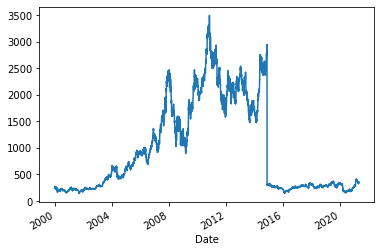

In [3]:
#Plotting the data for stock over time
df['Close'].plot()

### ACF(Auto Correlation Fuction) and PACF(Partial Auto Correlation Fuction)

$S_{t}$ --> data for today<br>
$S_{t-1}$ --> data from 1 day before<br>
$S_{t-2}$ --> data from 2 days before<br>

ACF and PACF are majorly used to find the correlation between the past data points to current data points.

##### In ACF for any lag(smallest number of units we are looking in the past) we are considering the data we check the correlation between each intermediate data points and describe the relationship in this plot

##### In PACF we do not care for intermediate correlation we check direct correlation between two data that the shorter lags between those observations do not explain.


> **A rule of thumb in any time series modelling is that we work with only stationary time series. If the series exhibits any non-stationarity, we have to remove that before we can employ any empirical analysis.**


### Stationarity
#### What is mean by Stationarity ?
Stationary data means data which have 
µ - mean - constant
σ - standard deviation - constant
No seasonality present in the data. Means there are no regular and predictable changes that reocur every calendar year


#### Unit Roots
If the time series data has unit root then it is not stationary. Name unit root comes from the mathematical definition of it. It becomes imperative to remove the unit root from the data so that data becomes stationary and analysis and forecasting issues are taken care.

#### Checking for Stationarity
1. Visually - observing the data 
2. ADF test - (Augmented Dickey Fuller Test)

#### Converting Time Series into Stationary data
- Log transforming of the data
- Taking the square root of the data
- Taking the cube root
- Proportional change

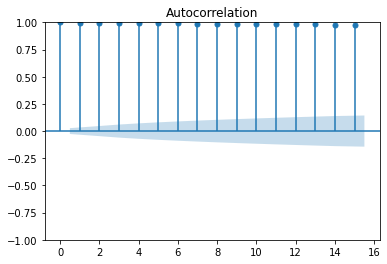

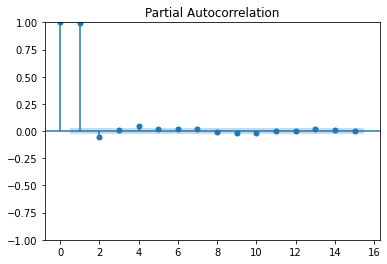

In [4]:
plot_acf(df['Close'],lags = 15);
plot_pacf(df['Close'],lags = 15);

In [5]:
def adf_test(series):
    '''
    **Perform Dickey-Fuller Test
    
    1. Test for the stationarity of the data
    2. Provide series of Non null data and it returns the statistic and p-value
       with message to accept or reject the null hypothesis and stationarity of the data
    '''
    result = adfuller(series.dropna())
    labels = ['ADF Test Statistic','p-value','# Used Lag','# Number of Observations']
    adf_test_stats = pd.DataFrame(result[0:4],index = labels)
    print(adf_test_stats[0])
    
    if result[1] < 0.05:
        print("Reject the Null hypothesis")
        print("Data is Stationary")
    else:
        print("Failed to reject the null hypothesis")
        print("Data is not Stationary")

In [6]:
#For Any model to fit to time series data we need the data in stationary form.
#There are many ways to convert the data into stationary form
def stationary_sqrt_transform(series):
    '''
    **Convert Non stationary data to Stationary data and ADF test for Stationarity
    
    1. Take the series of data as input
    2. Take square root of the data
    3. Shift the data and take difference between original data and 
    4. Shifted data both using diff() function in pandas
    '''
    df_log=np.sqrt(series)
    df_diff=df_log.diff().dropna()
    print(adf_test(df_diff))
    return df_diff
df_diff = stationary_sqrt_transform(df['Close'])

ADF Test Statistic           -43.075618
p-value                        0.000000
# Used Lag                     2.000000
# Number of Observations    5302.000000
Name: 0, dtype: float64
Reject the Null hypothesis
Data is Stationary
None


## Time Series Forecasting

### AR Model
1. In Auto regressive model we try to predict something in the future based on the past values of the same thing. Hence called Auto and as we will predict the continuous values the prediction will be regressive.


2. In AR model we try to find the pattern between the relationship between different lag values of the same series. 

    Eg.<br>
    $m_{t}$ -> Milk shipped in this month<br>
    $m_{t-1}$ -> Milk shipped in the last month<br>
    $m_{t-2}$ -> Milk shipped two months back<br>


3. There may be some pattern and relation between current data and lag data for first or second or nth lag but we don't know. This can be found out using **PACF** plot. If value of correlation for particular lag value crosses the significance the lag is useful in building an AR Model

Train Data Size =  7010
Test Data Size =  778
Time Required to Fit the model = 0.002515554428100586
                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                 7010
Model:                     AutoReg(4)   Log Likelihood              -35783.116
Method:               Conditional MLE   S.D. of innovations             39.987
Date:                Sun, 11 Sep 2022   AIC                          71578.232
Time:                        15:06:04   BIC                          71619.359
Sample:                    01-07-2000   HQIC                         71592.403
                         - 03-13-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1183      0.746      1.499      0.134      -0.344       2.581
Close.L1       1.0347      0.01

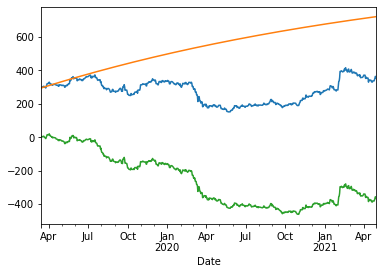

In [7]:
def build_AR_model(ser,lag):
    #SETTING THE FREQUENCY BY INFERRING FROM THE DATA ITSELF
    ser = ser.asfreq(pd.infer_freq(df.index))
    ser = ser.fillna(method="ffill")
    
    train_data = ser.iloc[:int(ser.shape[0]*.9)]
    print("Train Data Size = ",train_data.shape[0])
    test_data = ser.iloc[int(ser.shape[0]*.9) + 1:]
    print("Test Data Size = ",test_data.shape[0])

    model = AutoReg(train_data, lags=lag)
    
    start = time()
    model_fit = model.fit()
    end = time()
    print("Time Required to Fit the model =",end-start)
    
    print(model_fit.summary())

    #Prediction Start and End Date
    pred_start_date = test_data.index[0]
    pred_end_date = test_data.index[-1]
    print("Start Date For Predictions = ",pred_start_date)
    print("End Date For Predictions = ",pred_end_date)

    predictions = model_fit.predict(start = pred_start_date,end = pred_end_date)
    residuals = test_data - predictions

    print("Mean Absolute Percent Error = ",round(np.mean(abs(residuals/test_data)),4))
    print("Root Mean Squared Error = ",np.sqrt(np.mean(residuals**2)))
    
    return test_data,predictions,residuals
test_data,predictions,residuals = build_AR_model(df['Close'],4)

test_data.plot()
predictions.plot()

plt.plot(residuals)







Date
2000-01-03    243.65
2000-01-04    259.10
2000-01-05    248.45
2000-01-06    261.00
2000-01-07    273.30
               ...  
2019-03-10    281.20
2019-03-11    287.35
2019-03-12    286.90
2019-03-13    293.15
2019-03-14    291.90
Freq: D, Name: Close, Length: 7011, dtype: float64


<AxesSubplot:>

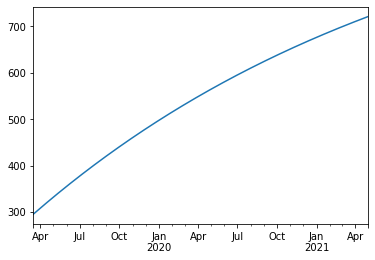

In [8]:
## TODO HAS BETTER PERFORMANCE THAN SIMPLE AR MODEL
def build_AR_model_with_rolling(ser,lag):
    ser = ser.asfreq(pd.infer_freq(df.index))
    ser = ser.fillna(method="ffill")
    predictions_rolling = pd.Series()
    test_data = ser.iloc[int(ser.shape[0]*.9) + 1:]
    for end_date in test_data.index:
        train_data = ser[:end_date - timedelta(days = 1)]
        print(train_data)
        model = AutoReg(train_data, lags=lag)
        model_fit = model.fit()
        pred = model_fit.predict(start = end_date,end = end_date)
        predictions_rolling.loc[end_date] = pred.loc[end_date]
        return predictions_rolling
predictions_rolling = build_AR_model_with_rolling(df['Close'],4)
predictions.plot()

### MA Model

In Moving Average Model. The order 1 MA models looks like this<br><br>
$f_{t}$ = µ + Φ1($ε_{t-1}$)

as order increases the equation will increase with each order having its own term and coefficients



Train Data Size =  7010
Test Data Size =  778
Time Required to Fit the model = 8.122607469558716
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 7010
Model:                 ARIMA(0, 0, 2)   Log Likelihood              -48995.571
Date:                Sun, 11 Sep 2022   AIC                          97999.143
Time:                        15:06:13   BIC                          98026.563
Sample:                    01-03-2000   HQIC                         98008.591
                         - 03-13-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1042.9460     11.771     88.601      0.000    1019.875    1066.017
ma.L1          1.6473      0.003  

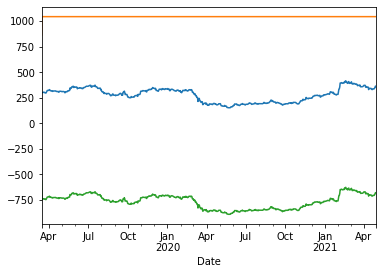

In [9]:
def build_MA_model(ser,lag):
    #SETTING THE FREQUENCY BY INFERRING FROM THE DATA ITSELF
    ser = ser.asfreq(pd.infer_freq(df.index))
    ser = ser.fillna(method="ffill")
    
    train_data = ser.iloc[:int(ser.shape[0]*.9)]
    print("Train Data Size = ",train_data.shape[0])
    test_data = ser.iloc[int(ser.shape[0]*.9) + 1:]
    print("Test Data Size = ",test_data.shape[0])

    model = sm.tsa.arima.ARIMA(train_data, order=(0,0,2))
    
    start = time()
    model_fit = model.fit()
    end = time()
    print("Time Required to Fit the model =",end-start)
    
    print(model_fit.summary())

    #Prediction Start and End Date
    pred_start_date = test_data.index[0]
    pred_end_date = test_data.index[-1]
    print("Start Date For Predictions = ",pred_start_date)
    print("End Date For Predictions = ",pred_end_date)

    predictions = model_fit.predict(start = pred_start_date,end = pred_end_date)
    residuals = test_data - predictions

    print("Mean Absolute Percent Error = ",round(np.mean(abs(residuals/test_data)),4))
    print("Root Mean Squared Error = ",np.sqrt(np.mean(residuals**2)))
    
    return test_data,predictions,residuals#create the model
test_data,predictions,residuals = build_MA_model(df['Close'],4)
test_data.plot()
predictions.plot()

plt.plot(residuals)